# U.S. Embassy in San José (Costa Rica) - Air quality prediction using machine learning

The objective of this work is to implement a machine learning model based on a neural network LSTM for the prediction of the concentration of pm 2.5 in the air according to certain dates. For this purpose, a dataset containing information on the concentration of particulate matter in the surroundings of the U.S. Embassy in San Jose, Costa Rica is used; this dataset collects data for the last 41 weeks (as of April 29, 2023), and the concentration of pm 2.5 on that date [1].

## Loading the Libraries 📚

In [202]:
import pandas as pd # for data handling
import numpy as np # for mathematical and linear algebra
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for data visualization

# Model libraries
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split

%matplotlib inline

## Loading the Dataset 📅

In [203]:
df = pd.read_csv('https://raw.githubusercontent.com/Emmazch22/Air_Quality_Prediction/main/data/san-jose_us_embassy-air-quality.csv')

Let's display the first 10 records of the data set

In [204]:
df.head(10)

,date,pm25
0,2023/4/2,27
1,2023/4/3,20
2,2023/4/4,17
3,2023/4/5,11
4,2023/4/6,21
5,2023/4/7,19
6,2023/4/8,20
7,2023/4/9,22
8,2023/4/10,16
9,2023/4/12,40


## Data Preprocessing 🧹

Since the dataset is composed of date and value of pm2.5, let's convert the data in the date column to datetime format.

In [205]:
df['date'] = pd.to_datetime(df['date'])
# Sort the dates 
df = df.sort_values(by='date')

Now let's check if the data transformation has been performed.

In [206]:
df.head(10)

,date,pm25
1122,2019-12-05,31
1123,2019-12-06,24
1124,2019-12-07,33
1125,2019-12-08,31
1126,2019-12-09,16
1127,2019-12-10,22
1128,2019-12-11,29
1129,2019-12-12,29
1130,2019-12-13,23
1131,2019-12-14,33


Let's check the columns and their names.

In [207]:
print(df.columns)

Index(['date', ' pm25'], dtype='object')


To facilitate the handling of the column ' pm25' its name will be changed

In [208]:
df.rename(columns={' pm25': 'pm25'}, inplace=True)

Null values, Empty values and NaN, could represent a major problem in data quality, and therefore, in the performance of the machine learning model. Consequently, let's check if such values exist.

In [209]:
print(f"Number of null values: {df.isnull().sum().sum()}")
print(f"Number of empty values: {(df == '').sum().sum()}")
print(f"Number of NaN values: {df.isna().sum().sum()}")

Number of null values: 0
Number of empty values: 0
Number of NaN values: 0


Since the dataset does not present problematic values, we proceed with the exploratory analysis to identify patterns in the data.

## Exploratory Analysis 📊

In [210]:
print(f"Shape of the dataset: {df.shape}")

Shape of the dataset: (1148, 2)


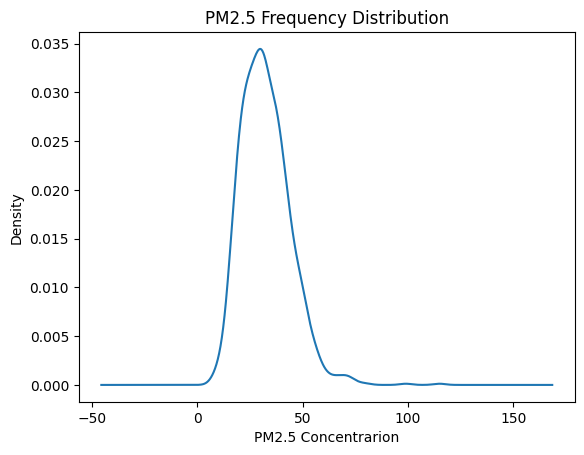

In [211]:
df['pm25'].plot(kind='density')

plt.title('PM2.5 Frequency Distribution')
plt.xlabel('PM2.5 Concentrarion')
plt.ylabel('Density')


plt.show()

It can be observed that the data have a positive asymmetric distribution, which allows the application of certain data transformation techniques, such as: logarithmic or square root transformation; in case outliers are found in the data.

Let's evaluate the box plots to determine if there are outliers.

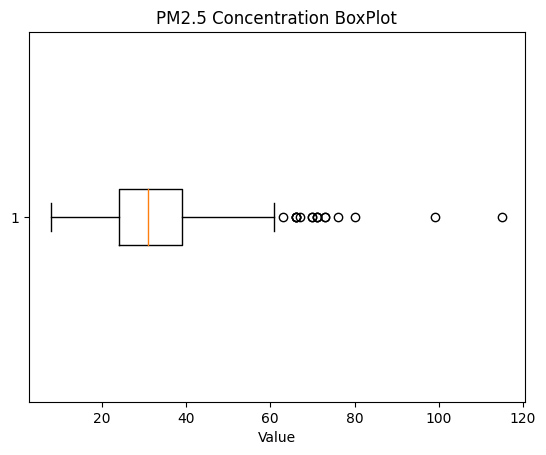

In [212]:
data = df['pm25']

# Create the boxplot
fig, ax = plt.subplots()
ax.boxplot(data, vert=False)
ax.set_title('PM2.5 Concentration BoxPlot')
ax.set_xlabel('Value')
plt.show()

Since the outliers are very extreme and cannot be explained by the distribution of the data, then the transformation may not be effective in removing them, therefore, we proceed to replace the outliers with the median.

In [213]:
q1 = df['pm25'].quantile(0.25)
q3 = df['pm25'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

df.loc[(df['pm25'] < lower_bound) | (df['pm25'] > upper_bound), 'pm25'] = df['pm25'].median()

Let's evaluate the box plots for outliers after replacement.

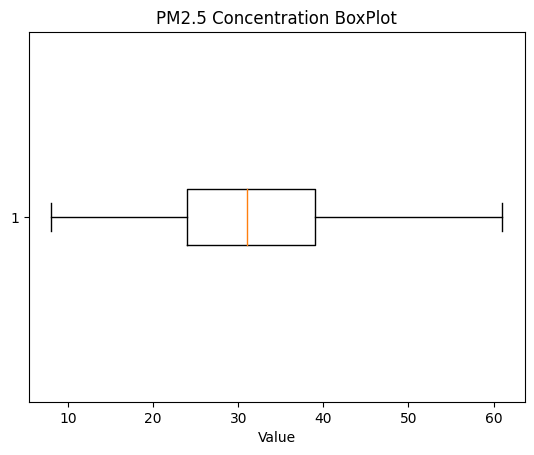

In [214]:
data = df['pm25']

# Create the boxplot
fig, ax = plt.subplots()
ax.boxplot(data, vert=False)
ax.set_title('PM2.5 Concentration BoxPlot')
ax.set_xlabel('Value')
plt.show()

Now that the outliers have been replaced, we ensure that our machine learning model is more accurate and performs better.

The following is a time series graph showing the evolution of PM2.5 concentration in air over time. This type of graph is important because it allows us to visualise patterns and trends over time and also to identify any anomalous events or changes in the time series.

In [215]:
#df.head()
print(df.columns)

Index(['date', 'pm25'], dtype='object')


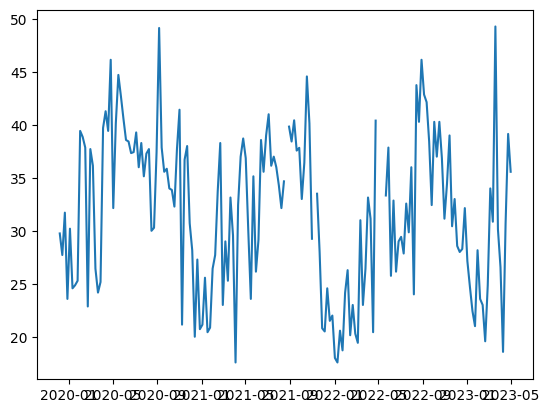

In [216]:
df_weekly = df.groupby(pd.Grouper(key='date', freq='W')).mean()
plt.plot(df_weekly)
plt.show()

It is possible to observe how after large peaks of PM 2.5 concentration in the air, there is usually a drop in the concentrations.

## Long Short-Term Memory Model for Data Prediction 🤖

The creation of test and training sets is presented below. For this purpose, a ratio of 80:20 is established.

In [217]:
# convert date into a timestamp format
df['date'] = pd.to_datetime(df['date']).apply(lambda x: x.timestamp())

In [218]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('pm25', axis=1), df['pm25'], test_size=0.2)

In [219]:
n_timesteps = 1
n_features = 1
X_train = X_train.values.reshape((X_train.shape[0], n_timesteps, n_features))
X_test = X_test.values.reshape((X_test.shape[0], n_timesteps, n_features))

The LSTM-based model is then created and configured for prediction.

In [220]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

The neural network training is then performed. This adjusts the weights and internal parameters of the model so that it can make accurate predictions on new data. For this purpose, 50 epochs and a verbose of 1 are defined.

In [221]:
model.fit(X_train, y_train, epochs=50, verbose=1)


Epoch 1/50
29/29 [==============================] - 2s 3ms/step - loss: 16765050421248.0000
Epoch 2/50
29/29 [==============================] - 0s 3ms/step - loss: 490003628032.0000
Epoch 3/50
29/29 [==============================] - 0s 3ms/step - loss: 25298405376.0000
Epoch 4/50
29/29 [==============================] - 0s 3ms/step - loss: 1510091520.0000
Epoch 5/50
29/29 [==============================] - 0s 3ms/step - loss: 66599676.0000
Epoch 6/50
29/29 [==============================] - 0s 3ms/step - loss: 3372467.5000
Epoch 7/50
29/29 [==============================] - 0s 3ms/step - loss: 237640.6250
Epoch 8/50
29/29 [==============================] - 0s 3ms/step - loss: 8017.6362
Epoch 9/50
29/29 [==============================] - 0s 3ms/step - loss: 658.5139
Epoch 10/50
29/29 [==============================] - 0s 3ms/step - loss: 127.7396
Epoch 11/50
29/29 [==============================] - 0s 3ms/step - loss: 108.3020
Epoch 12/50
29/29 [==============================] - 0s 3ms

In [222]:
mse = model.evaluate(X_test, y_test, verbose=0)
print('Mean Squared Error: %.3f' % mse)

Mean Squared Error: 120.212


## Prediction 📈

### How to use:
To predict the concentration of pm 2.5, the date must be changed in the date variable (follow the specified format), then the model will show the prediction made for that date.

In [230]:
import datetime as dt
# Change this variable to predict the pm 2.5
date = '2023-04-30' # follow the format Y-M-D
datetime = dt.datetime.strptime(date, '%Y-%m-%d')
prediction_date = pd.Timestamp(datetime).timestamp()

In [231]:
X_new = np.array(prediction_date).reshape((1, n_timesteps, n_features))
y_pred = model.predict(X_new)

1/1 [==============================] - 0s 23ms/step


In [234]:
print(f"Prediction for {date}:\npm 2.5 Concentration: {y_pred}")

Prediction for 2023-04-30:
pm 2.5 Concentration: [[35.991245]]


## References

[1] aqicn.org, *“San Jose US Embassy Air Pollution: Real-time Air Quality Index (AQI)”*, [Online]. Available: https://aqicn.org/city/costa-rica/san-jose/us-embassy/. [Accesed at: 29-apr-2023].

Performed by: Emmanuel Zúñiga Chaves.
Contact: emanuel2202zch@gmail.com